# 有限要素法による二次元静弾性解析

In [ ]:
using LinearAlgebra
module Fem2d
    mutable struct Stress
        σx::Real
        σy::Real
        τxy::Real
    end

    mutable struct Element
        node::Array{Int, 1}
        ym::Real
        po::Real
        thick::Real
    end

    mutable struct Node
        x::Real
        y::Real
        bcx::Real
        bcy::Real
        xbt::Int
        ybt::Int
    end

    struct Param
        ξ::Array{Real, 1} #要素座標ξ
        η::Array{Real, 1} #要素座標η
        gu::Array{Real, 1} #Gauss-Legendre積分の積分点
        gw::Array{Real, 1} #Gauss-Legendre積分の重み
    end

    #要素内の節点は右上の角から反時計回りで要素座標xiとeta
    ξ = [1.0, 0.0, -1.0, -1.0, -1.0, 0.0, 1.0, 1.0]
    η = [1.0, 1.0, 1.0, 0.0, -1.0, -1.0, -1.0, 0.0]
    #Gauss-Legendre4点積分の座標、重み
    uip = sqrt(3.0 + 2.0*sqrt(6.0/5.0))/7.0
    uim = sqrt(3.0 - 2.0*sqrt(6.0/5.0))/7.0
    gu = [-uip, -uim, uim, uip]
    wip = (18.0 + sqrt(30.0))/36.0
    wim = (18.0 - sqrt(30.0))/36.0
    gw = [wim, wip, wip, wim]

    param = Param(ξ, η, gu, gw)

    function read_node(no, pos, disx, disy, loadx, loady)
        nd = Array{Node}(undef, no)

        for i=1:no
            nd[i] = Node(pos[i, 1], pos[i, 2], 0.0, 0.0, 1, 1)
        end
        s = size(disx)[1]
        if s > 0
            for i = 1:s
                nd[disx[i].node].bcx = disx[i].value
                nd[disx[i].node].xbt = 0
            end 
        end
        s = size(disy)[1]
        if s > 0
            for i = 1:s
                nd[disy[i].node].bcy = disy[i].value
                nd[disy[i].node].ybt = 0
            end
        end 
        s = size(loadx)[1]
        if s > 0
            for i = 1:s
                nd[loadx[i].node].bcx = loadx[i].value
            end
        end
        s = size(loady)[1]
        if s > 0
            for i = 1:s
                nd[loady[i].node].bcy = loady[i].value
            end
        end

        return nd
    end #read_node

    function read_element(el, cond)
        elem = Array{Element}(undef, el)
        for i=1:el
            elem[i] = Element(cond[i].nodes, cond[i].ym, cond[i].po, cond[i].thick)
        end
        return elem
    end #read_element

    function make_stiffness(no, el, nd, elem)
        kmat = zeros(2*no, 2*no)
        for ie = 1:el
            dmat = make_dmat(elem[ie])

            emat = zeros(16, 16)
            tmat = zeros(16, 16)
            for i=1:4
                nξ = param.gu[i]
                for j=1:4
                    nη = param.gu[j]
                    bmat, det = make_bmat(elem[ie], no, nd, nξ, nη)
                    emat = bmat' * dmat * bmat
                    tmat = tmat + det*emat*param.gw[i]*param.gw[j]*elem[ie].thick
                end
            end

            for i=1:8
                p = elem[ie].node[i]
                for j=1:8
                    q = elem[ie].node[j]
                    kmat[2*q-1, 2*p-1] = kmat[2*q-1, 2*p-1] + tmat[2*j-1, 2*i-1]
                    kmat[2*q, 2*p-1] = kmat[2*q, 2*p-1] + tmat[2*j, 2*i-1]
                    kmat[2*q-1, 2*p] = kmat[2*q-1, 2*p] + tmat[2*j-1, 2*i]
                    kmat[2*q, 2*p] = kmat[2*q, 2*p] + tmat[2*j, 2*i]
                end
            end
        end

        return kmat
    end #make_stiffness

    function make_dmat(elem)
        f = elem.ym/(1.0 - elem.po^2)
        dmat = [f elem.po*f 0.0;
                elem.po*f f 0.0;
                0.0 0.0 ((1.0 - elem.po)/2.0)*f]

        return dmat
    end #make_dmat

    function make_bmat(elem, no, nd, nξ, nη)
        jacobian = zeros(2, 2)

        for i=1:8
            p = elem.node[i]
            jacobian[1, 1] = jacobian[1, 1] + nd[p].x * dndξ(i, nξ, nη)
            jacobian[1, 2] = jacobian[1, 2] + nd[p].y * dndξ(i, nξ, nη)
            jacobian[2, 1] = jacobian[2, 1] + nd[p].x * dndη(i, nξ, nη)
            jacobian[2, 2] = jacobian[2, 2] + nd[p].y * dndη(i, nξ, nη)
        end

        det = jacobian[1, 1]*jacobian[2, 2] - jacobian[1, 2]*jacobian[2, 1]

        bmat = zeros(3, 16)

        for i=1:8
            dndx = (jacobian[2, 2]*dndξ(i, nξ, nη) - jacobian[1, 2]*dndη(i, nξ, nη))/det
            dndy = (-jacobian[2, 1]*dndξ(i, nξ, nη) + jacobian[1, 1]*dndη(i, nξ, nη))/det
            bmat[1, 2*i-1] = dndx
            bmat[2, 2*i] = dndy
            bmat[3, 2*i-1] = dndy
            bmat[3, 2*i] = dndx
        end

        det = abs(det)

        return bmat, det
    end #make_bmat

    function ni(i, nξ, nη)
        ξ = param.ξ[i]
        η = param.η[i]
        
        z = (1.0 + nξ*ξ)*(1.0 + nη*η)*(nξ*ξ + nη*η - 1.0)*ξ^2*η^2/4.0 + (1.0 - nξ^2)*(1.0 + nη^2)*(1.0 - ξ^2)/2.0 + (1.0 - η^2)*(1.0 + nξ*ξ)*(1.0 - η^2)/2.0
        return z
    end #ni

    function dndξ(i, nξ, nη)
        ξ = param.ξ[i]
        η = param.η[i]

        z = (1.0 + nη*η)*ξ^3*η^2*(2.0*nξ*ξ + nη*η)/4.0 - nξ*(1.0 + nη*η)*(1.0 - ξ^2) + (1.0 - nη^2)*ξ*(1.0 - η^2)/2.0

        return z
    end #dndξ

    function dndη(i, nξ, nη)
        ξ = param.ξ[i]
        η = param.η[i]

        z = z = (1.0 + nξ*ξ)*ξ^2*η^3*(nξ*ξ + 2.0*nη*η)/4.0 + (1.0 - nξ^2)*η*(1.0 - ξ^2)/2.0 - nη*(1.0 + nξ*ξ)*(1.0 - η^2)
        return z
    end #dndη


    function set_bc(no, el, nd, elem, kmat, dvec)
        for i=1:no
            dvec[2*i-1] = nd[i].bcx
            dvec[2*i] = nd[i].bcy

            if nd[i].xbt == 0
                for j=1:2*no
                    kmat[2*i-1, j] = 0.0
                end
                kmat[2*i-1, 2*i-1] = 1.0
            end

            if nd[i].ybt == 0
                for j=1:2*no
                    kmat[2*i, j] = 0.0
                end
                kmat[2*i, 2*i] = 1.0
            end
        end
    end #set_bc

    function make_stress(no, nd, elem, uvec, ξ, η)
        jacobian = zeros(2, 2)
        dmat = make_dmat(elem)
        bmat, det = make_bmat(elem, no, nd, ξ, η)
        s = Stress(0.0, 0.0, 0.0)

        db = dmat*bmat

        for i=1:8
            j = elem.node[i]
            s.σx = s.σx + db[1, 2*i-1]*uvec[2*j-1] + db[1, 2*i]*uvec[2*j]
            s.σy = s.σy + db[2, 2*i-1]*uvec[2*j-1] + db[2, 2*i]*uvec[2*j]
            s.τxy = s.τxy + db[3, 2*i-1]*uvec[2*j-1] + db[3, 2*i]*uvec[2*j]
        end
        return s
    end #make_stress

    function run_fem(el, no, st, nd, elem)
        dvec = zeros(2*no)
        kmat = make_stiffness(no, el, nd, elem)
        set_bc(no, el, nd, elem, kmat, dvec)
        x = kmat\dvec

        return x
    end #run_fem

end #Fem2d

Main.Fem2d

In [ ]:
no = 13

pos = [0.0 0.2;
0.1 0.2;
0.2 0.2;
0.3 0.15;
0.4 0.1;
0.4 0.05;
0.4 0.0;
0.3 0.0;
0.2 0.0;
0.2 0.1;
0.0 0.1;
0.0 0.0;
0.1 0.0]

disx = [(node = 1,  value = 0.0), (node = 11, value = 0.0), (node = 12, value = 0.0)]

disy = [(node = 12, value = 0.0)]

loadx = [(node = 5, value = 50.0), (node = 6, value = 75.0), (node = 7, value = 100.0)]

loady = []

using .Fem2d
nd = Fem2d.read_node(no, pos, disx, disy, loadx, loady)

13-element Vector{Main.Fem2d.Node}:
 Main.Fem2d.Node(0.0, 0.2, 0.0, 0.0, 0, 1)
 Main.Fem2d.Node(0.1, 0.2, 0.0, 0.0, 1, 1)
 Main.Fem2d.Node(0.2, 0.2, 0.0, 0.0, 1, 1)
 Main.Fem2d.Node(0.3, 0.15, 0.0, 0.0, 1, 1)
 Main.Fem2d.Node(0.4, 0.1, 50.0, 0.0, 1, 1)
 Main.Fem2d.Node(0.4, 0.05, 75.0, 0.0, 1, 1)
 Main.Fem2d.Node(0.4, 0.0, 100.0, 0.0, 1, 1)
 Main.Fem2d.Node(0.3, 0.0, 0.0, 0.0, 1, 1)
 Main.Fem2d.Node(0.2, 0.0, 0.0, 0.0, 1, 1)
 Main.Fem2d.Node(0.2, 0.1, 0.0, 0.0, 1, 1)
 Main.Fem2d.Node(0.0, 0.1, 0.0, 0.0, 0, 1)
 Main.Fem2d.Node(0.0, 0.0, 0.0, 0.0, 0, 0)
 Main.Fem2d.Node(0.1, 0.0, 0.0, 0.0, 1, 1)

In [ ]:
el = 2

e = [(nodes = [1, 2, 3, 10, 9, 13, 12, 11], ym = 208.e+9, po = 0.25, thick = 5.e-3) 
(nodes = [3, 4, 5, 6, 7, 8, 9, 10], ym = 208.e+9, po = 0.25, thick = 3.5e-3)]

using .Fem2d
elem = Fem2d.read_element(el, e)

2-element Vector{Main.Fem2d.Element}:
 Main.Fem2d.Element([1, 2, 3, 10, 9, 13, 12, 11], 2.08e11, 0.25, 0.005)
 Main.Fem2d.Element([3, 4, 5, 6, 7, 8, 9, 10], 2.08e11, 0.25, 0.0035)

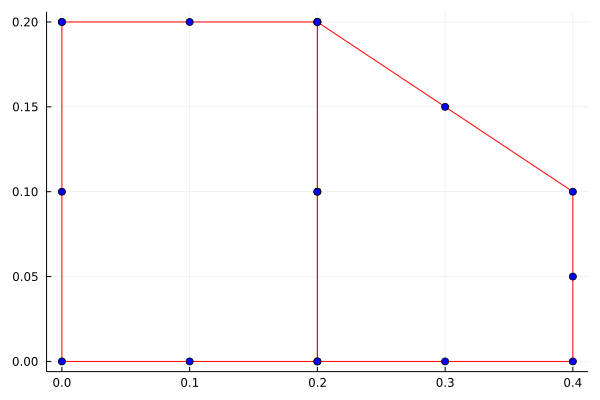

In [ ]:
using Plots

plot() #graph init
x = []
y = []
xmin = 0; ymin = 0; xmax = 0; ymax = 0
for i = 1:el
    nx = []
    ny = []
    for j = 1:8
        p = elem[i].node[j]
        push!(nx, nd[p].x)
        push!(ny, nd[p].y)
        if xmin > nd[p].x
            xmin = nd[p].x
        end
        if ymin > nd[p].y
            ymin = nd[p].y
        end
        if xmax < nd[p].x
            xmax = nd[p].y
        end
        if ymax < nd[p].y
            ymax = nd[p].y
        end
    end
    push!(nx, nx[1])
    push!(ny, ny[1])
    push!(x, nx)
    push!(y, ny)
    plot!(nx, ny, color = :red, legend = nothing)
    scatter!(nx, ny, color = :blue)
end

plot!() #graph plot


In [ ]:
using .Fem2d
st = 0
dvec = 0
dvec = Fem2d.run_fem(el, no, st, nd, elem)

26-element Vector{Float64}:
 -1.2017777387214171e-20
 -1.00591521381554e-6
 -1.6847595566974168e-6
  4.2645515895489723e-7
 -3.5924371680576586e-6
  2.797655347081153e-6
 -3.2295657209601454e-6
  8.826151743743327e-6
  4.292895833954873e-6
  1.7238656838765338e-5
  4.563875481142705e-6
  1.9068769895750726e-5
  1.2098999162283836e-5
  2.0052092093669866e-5
  9.528445441810935e-6
  8.827118219769908e-6
  1.9958348563518696e-6
  2.7862319076031746e-6
  2.6884830068011653e-7
  2.258153342609444e-6
 -3.1456630756275204e-22
 -3.5161001966108595e-7
  0.0
 -0.0
  9.500420666753599e-7
  4.654628553771178e-7

In [ ]:
println("x\t", "y\t", "u\t", "v\t")
for i = 1:el
    for j = 1:8
        p = elem[i].node[j]
        println(nd[p].x, "\t", nd[p].y, "\t", dvec[2*p-1], "\t", dvec[2*p])
    end
    println("\n")
end

x	y	u	v	
0.0	0.2	-1.2017777387214171e-20	-1.00591521381554e-6
0.1	0.2	-1.6847595566974168e-6	4.2645515895489723e-7
0.2	0.2	-3.5924371680576586e-6	2.797655347081153e-6
0.2	0.1	2.6884830068011653e-7	2.258153342609444e-6
0.2	0.0	1.9958348563518696e-6	2.7862319076031746e-6
0.1	0.0	9.500420666753599e-7	4.654628553771178e-7
0.0	0.0	0.0	-0.0
0.0	0.1	-3.1456630756275204e-22	-3.5161001966108595e-7


0.2	0.2	-3.5924371680576586e-6	2.797655347081153e-6
0.3	0.15	-3.2295657209601454e-6	8.826151743743327e-6
0.4	0.1	4.292895833954873e-6	1.7238656838765338e-5
0.4	0.05	4.563875481142705e-6	1.9068769895750726e-5
0.4	0.0	1.2098999162283836e-5	2.0052092093669866e-5
0.3	0.0	9.528445441810935e-6	8.827118219769908e-6
0.2	0.0	1.9958348563518696e-6	2.7862319076031746e-6
0.2	0.1	2.6884830068011653e-7	2.258153342609444e-6




In [ ]:
maxd = 0.0
for i = 1:no
    d = sqrt(dvec[2*i-1]*dvec[2*i-1] + dvec[2*i]*dvec[2*i])
    if d > maxd
        maxd = d
    end
end
newx = []
newy = []
d = sqrt((xmax - xmin)*(ymax - ymin))
factor = d/maxd*0.05

301.9309969422049

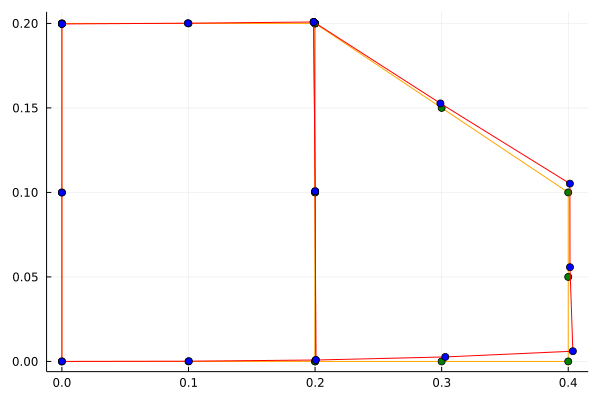

In [ ]:
using Plots

plot() #graph init

xmin = 0; ymin = 0; xmax = 0; ymax = 0
for i = 1:el
    nx = []
    ny = []
    for j = 1:8
        p = elem[i].node[j]
        push!(nx, nd[p].x + dvec[2*p-1]*factor)
        push!(ny, nd[p].y + dvec[2*p]*factor)
    end
    push!(nx, nx[1])
    push!(ny, ny[1])
    push!(newx, nx)
    push!(newy, ny)
    plot!(x[i, :], y[i, :], color = :orange, legend = nothing)
    scatter!(x[i, :], y[i, :], color = :green)
    plot!(nx, ny, color = :red)
    scatter!(nx, ny, color = :blue)
end

plot!() #graph plot
